In [1]:
# Upgrade environment to support TF 2.10 in Colab
!pip uninstall tensorflow --yes
!pip uninstall tensorflow-io --yes
# !pip install tensorflow-gpu
# !pip install --no-deps tensorflow-io
!pip install tensorflow==2.8.0
!pip install tensorflow-io==0.25.0

^C
  Using cached setuptools-69.0.2-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-69.0.2-py3-none-any.whl (819 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:
      Successfully uninstalled setuptools-65.5.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.8.0 which is incompatible.


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:

training_dir = r"C:\Users\mally\Leiden University [2022 -2024]\3rd Sem\API\Final Project\Train"
test_dir = r"C:\Users\mally\Leiden University [2022 -2024]\3rd Sem\API\Final Project\Test"

In [ ]:
chords = np.array(tf.io.gfile.listdir(str(training_dir)))
print('Chords:', chords)

Chords: ['Bb' 'Am' 'G' 'Dm' 'Bdim' 'C' 'F' 'Em']


In [ ]:
filenames = tf.io.gfile.glob(str(training_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of training examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(training_dir/chords[0]))))
print('Example file tensor:', filenames[0])

Number of training examples: 1440
Number of examples per label: 180
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/guitar-chords-v3/Training/Dm/Dm_AcousticGuitar_RodrigoMercador_3.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:1152]
val_files = filenames[-288:]
test_files = tf.io.gfile.glob(str(test_dir) + '/*/*')

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1152
Validation set size 288
Test set size 320


In [ ]:
test_file = tf.io.read_file(test_files[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file, desired_channels=1)
test_audio.shape

TensorShape([105152, 1])

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, sample_rate = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  audio = tf.squeeze(audio, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  return tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

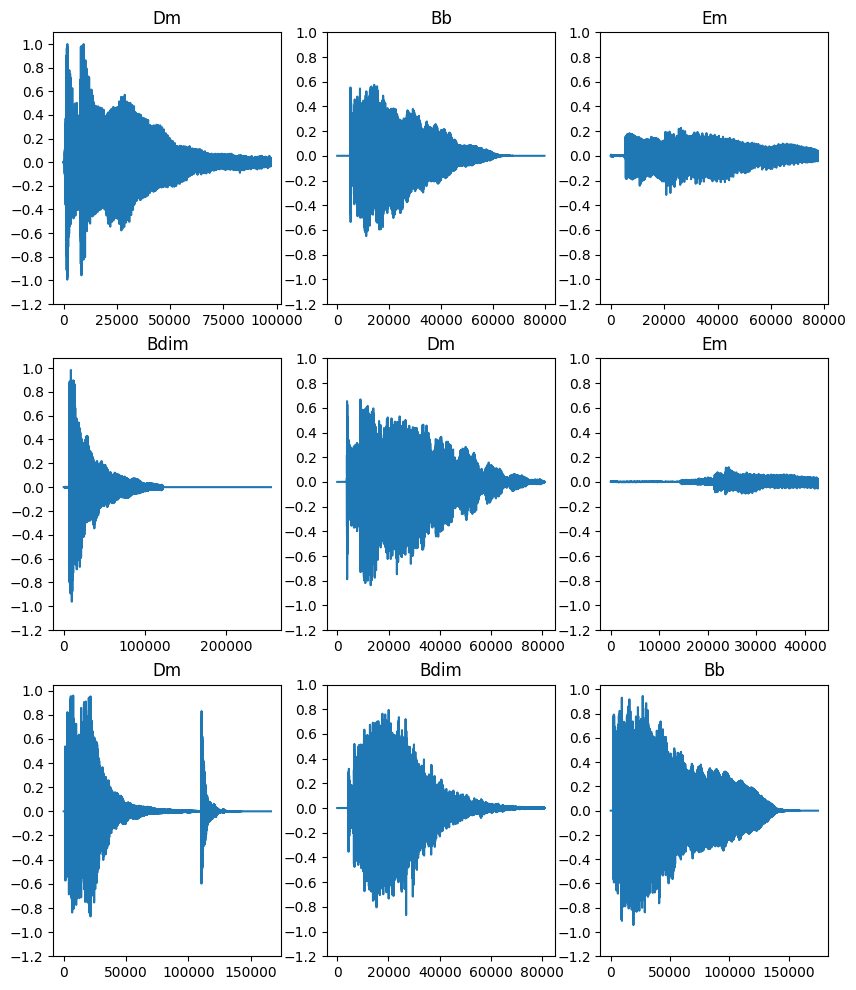

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=320, frame_step=32)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Dm
Waveform shape: (97338,)
Spectrogram shape: (491, 257, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

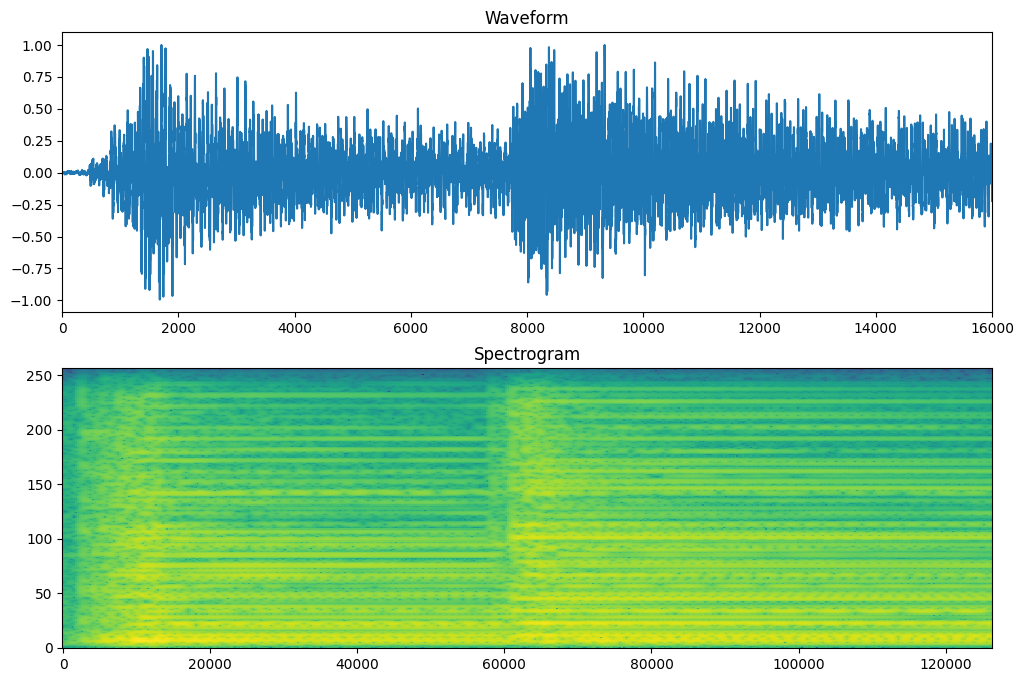

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == chords)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

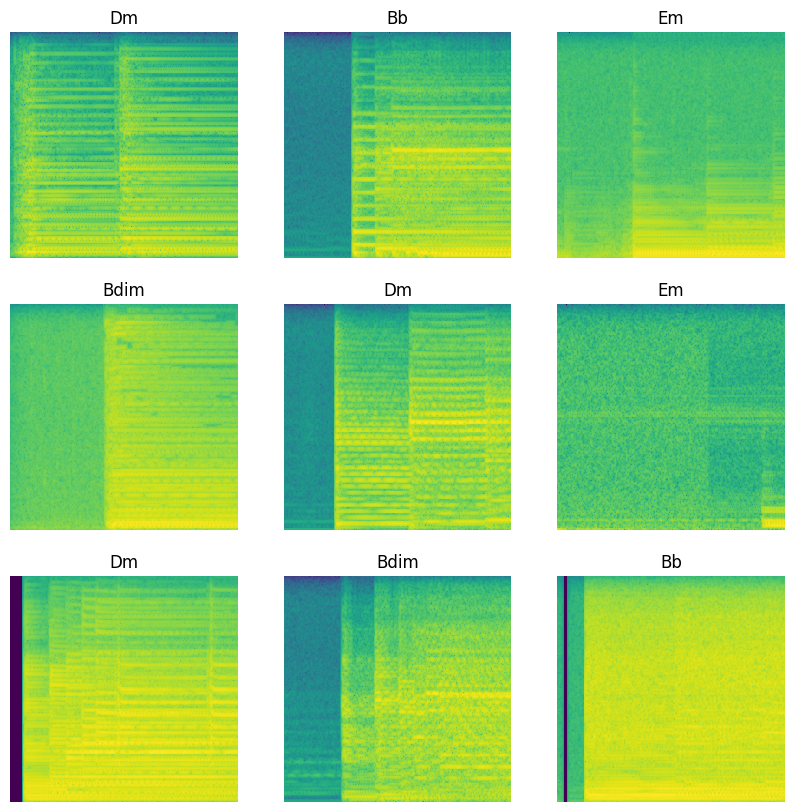

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(chords[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### **ResNet Model**

In [ ]:
for spectrogram, _ in spectrogram_ds.take(2):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(chords)

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='valid')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet(input_shape, num_labels):
    input_layer = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual Blocks
    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters, stride=2)
        for _ in range(1, 3):
            x = residual_block(x, filters, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_labels, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x)

    return model



# Build and compile the ResNet model
resnet_model = build_resnet(input_shape, num_labels)
# resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
resnet_model.summary()


Input shape: (491, 257, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 491, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 246, 129, 64  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_29 (BatchN  (None, 246, 129, 64  256        ['conv2d_29[0][0]']              
 ormalization)                  )                                

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 100
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
18/18 [==============================] - 9s 333ms/step - loss: 2.5743 - accuracy: 0.1562 - val_loss: 3201.0813 - val_accuracy: 0.1319
Epoch 2/100
18/18 [==============================] - 6s 307ms/step - loss: 2.0360 - accuracy: 0.2396 - val_loss: 75.6674 - val_accuracy: 0.1285
Epoch 3/100
18/18 [==============================] - 6s 311ms/step - loss: 1.8164 - accuracy: 0.3264 - val_loss: 2.1619 - val_accuracy: 0.2014
Epoch 4/100
18/18 [==============================] - 6s 313ms/step - loss: 1.4819 - accuracy: 0.4583 - val_loss: 1.7188 - val_accuracy: 0.2951
Epoch 5/100
18/18 [==============================] - 6s 314ms/step - loss: 1.2470 - accuracy: 0.5304 - val_loss: 1.6922 - val_accuracy: 0.3229
Epoch 6/100
18/18 [==============================] - 6s 317ms/step - loss: 1.0852 - accuracy: 0.6024 - val_loss: 2.0936 - val_accuracy: 0.4201
Epoch 7/100
18/18 [==============================] - 6s 309ms/step - loss: 1.0327 - accuracy: 0.6276 - val_loss: 3.2157 - val_accuracy: 0.

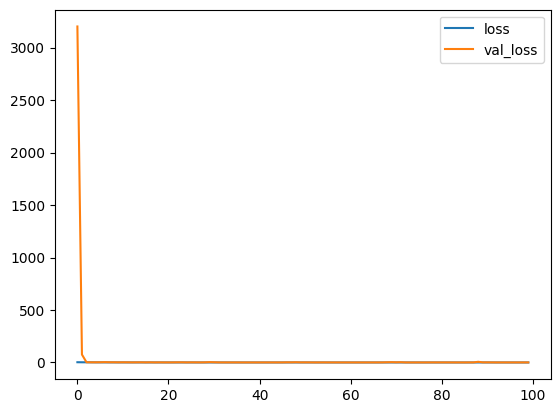

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(resnet_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 75%


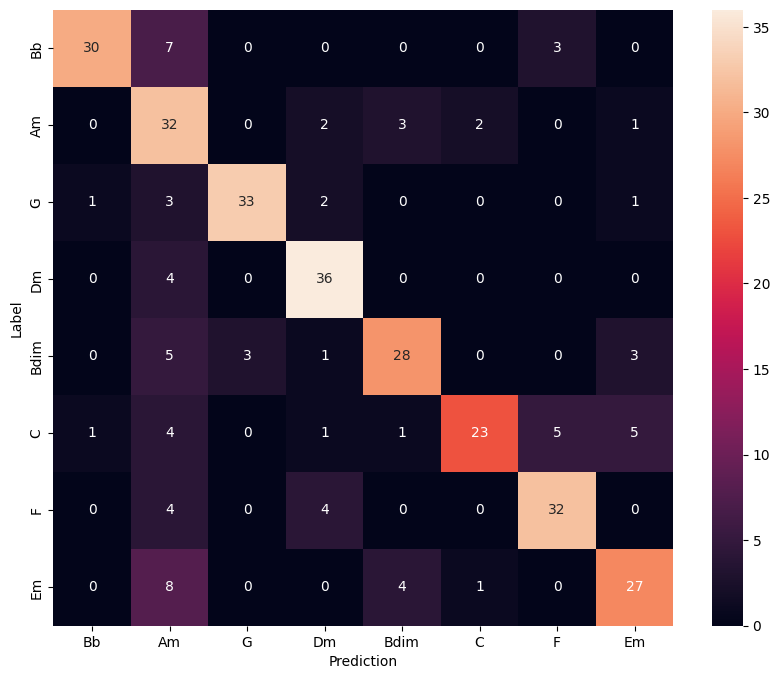

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=chords,
            yticklabels=chords,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

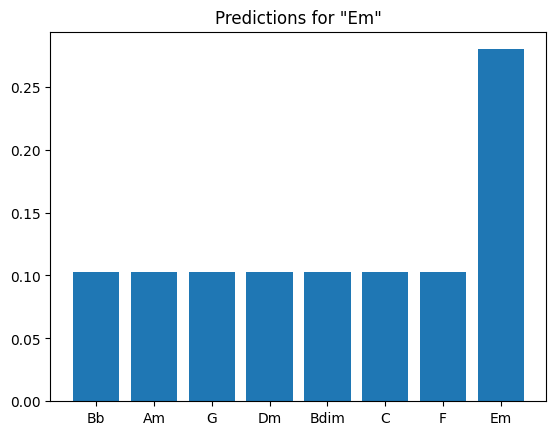

In [ ]:
sample_file = test_files[140]

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = resnet_model(spectrogram)
  plt.bar(chords, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{chords[label[0]]}"')
  plt.show()

In [ ]:
resnet_model.save('/content/drive/MyDrive/model_ResNet_100.keras')